# IMAGE PREPROCESSING

## Background Removal

In [ ]:
from PIL import Image
import os

def remove_white_background(input_path, output_path, compression_quality=85):
    # Open the image
    image = Image.open(input_path)

    # Convert the image to RGBA (if it's not already)
    image = image.convert('RGBA')

    # Get data of the image
    data = image.getdata()

    # Define a threshold to identify the white background
    threshold = 255
    new_data = []
    for item in data:
        # Set the pixel to transparent if it's white
        if item[0] > threshold and item[1] > threshold and item[2] > threshold:
            new_data.append((255, 255, 255, 0))  # White becomes transparent
        else:
            new_data.append(item)

    # Update the image data
    image.putdata(new_data)

    # Convert the image to RGB before saving as JPEG
    rgb_image = image.convert('RGB')

    # Save the result with compression
    rgb_image.save(output_path, quality=compression_quality)

# Dataset path
ds_path = r"dataset/images"

# Count the number of subfolders in the dataset path to determine the number of classes
class_folders = [f for f in os.listdir(ds_path) if os.path.isdir(os.path.join(ds_path, f))]
num_classes = len(class_folders)

print("Number of Classes: ", num_classes)
print("Classes: ", class_folders)

types = 0

for folder in class_folders:
    disease_folder = os.path.join(ds_path, folder)

    print('Processing images in folder: ', folder)

    # Create a folder for the processed images if it doesn't exist
    output_folder = os.path.join('dataset/other images', f"{folder}_processed")
    os.makedirs(output_folder, exist_ok=True)

    for image_name in os.listdir(disease_folder):
        input_image_path = os.path.join(disease_folder, image_name)
        output_image_path = os.path.join(output_folder, image_name)

        # Call the function to remove the white background and compress the image
        remove_white_background(input_image_path, output_image_path)


## Resizing Images

In [ ]:
from PIL import Image
import os

def resize_images(input_path, output_path, target_size=(256, 256), compression_quality=85):
    # Open the image
    image = Image.open(input_path)

    # Resize the image
    resized_image = image.resize(target_size)

    # Convert the image to RGB before saving as JPEG
    rgb_image = resized_image.convert('RGB')

    # Save the resized image with compression
    rgb_image.save(output_path, quality=compression_quality)

# Dataset path
ds_path = r"dataset/images"

# Count the number of subfolders in the dataset path to determine the number of classes
class_folders = [f for f in os.listdir(ds_path) if os.path.isdir(os.path.join(ds_path, f))]
num_classes = len(class_folders)

print("Number of Classes: ", num_classes)
print("Classes: ", class_folders)

for folder in class_folders:
    disease_folder = os.path.join(ds_path, folder)

    print('Processing images in folder: ', folder)

    # Create a folder for the processed images if it doesn't exist
    output_folder = os.path.join('dataset/other images', f"{folder}_processed")
    os.makedirs(output_folder, exist_ok=True)

    for image_name in os.listdir(disease_folder):
        input_image_path = os.path.join(disease_folder, image_name)
        output_image_path = os.path.join(output_folder, image_name)

        # Call the function to resize the image to 256 x 256 pixels and compress the image
        resize_images(input_image_path, output_image_path, target_size=(256, 256))

# EDI-FEATURES


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops

In [ ]:
ds_path = r"dataset/images"
diseases= os.listdir(ds_path)

In [ ]:
diseases

In [ ]:
from skimage import exposure
from skimage.feature import hog
from skimage.measure import regionprops
from scipy import stats
from skimage.measure import label

# Set the dataset path
ds_path = r"dataset/images"

def features():
    names = ['area', 'perimeter', 'physiological_length', 'physiological_width', 'aspect_ratio',
             'mean_r', 'mean_g', 'mean_b', 'stddev_r', 'stddev_g', 'stddev_b',
             'contrast', 'energy', 'homogeneity', 'correlation', 'dissimilarity',
             'eccentricity', 'solidity', 'equiv_diameter', 'major_axis_length', 'minor_axis_length',
             'skewness', 'kurtosis', 'hog_feature_1', 'hog_feature_2', 'hog_feature_3', 'types'
            ]
    df = pd.DataFrame(columns=names)

    # Count the number of subfolders in the dataset path to determine the number of classes (labels)
    class_folders = [f for f in os.listdir(ds_path) if os.path.isdir(os.path.join(ds_path, f))]
    num_classes = len(class_folders)

    print("Number of Classes: ", num_classes)
    print("Classes: ", class_folders)

    for folder in class_folders:
        disease_folder = os.path.join(ds_path, folder)

        print('Extracting features in folder: ', folder)
        types = folder
        index = 0
        image_count = 0  # Counter for the number of images in the folder
        
        for image in os.listdir(disease_folder):
            index = index + 1
            image_count += 1  # Increment the counter for each image
            imgpath = os.path.join(disease_folder, image)
            main_img = cv2.imread(imgpath)

            # Preprocessing
            img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
            gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            blur = cv2.GaussianBlur(gs, (25, 25), 0)
            ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            kernel = np.ones((50, 50), np.uint8)
            closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

            # Shape features
            contours, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            cnt = contours[0]
            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt, True)
            x, y, w, h = cv2.boundingRect(cnt)
            aspect_ratio = float(w) / h

            # Color features
            red_channel = img[:, :, 0]
            green_channel = img[:, :, 1]
            blue_channel = img[:, :, 2]

            red_mean = np.mean(red_channel)
            green_mean = np.mean(green_channel)
            blue_mean = np.mean(blue_channel)

            # Std deviation
            red_std = np.std(red_channel)
            green_std = np.std(green_channel)
            blue_std = np.std(blue_channel)

            # Texture features using GLCM matrix
            glcm = graycomatrix(gs,
                                distances=[1],
                                angles=[0],
                                symmetric=True,
                                normed=True)

            properties = ['contrast', 'energy', 'homogeneity', 'correlation', 'dissimilarity']
            contrast = graycoprops(glcm, properties[0])
            energy = graycoprops(glcm, properties[1])
            homogeneity = graycoprops(glcm, properties[2])
            correlation = graycoprops(glcm, properties[3])
            dissimilarity = graycoprops(glcm, properties[4])

            # Statistical moments
            skewness = stats.skew(gs.flatten())
            kurtosis = stats.kurtosis(gs.flatten())

            # Additional features
            labeled_img = label(closing)
            regions = regionprops(labeled_img)

            eccentricity = regions[0].eccentricity
            solidity = regions[0].solidity
            equiv_diameter = regions[0].equivalent_diameter
            major_axis_length = regions[0].major_axis_length
            minor_axis_length = regions[0].minor_axis_length

            # HOG features
            hog_features = hog(gs, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), block_norm='L2-Hys')

            vector = [area, perimeter, w, h, aspect_ratio,
                      red_mean, green_mean, blue_mean, red_std, green_std, blue_std,
                      contrast[0][0], energy[0][0], homogeneity[0][0], correlation[0][0], dissimilarity[0][0],
                      eccentricity, solidity, equiv_diameter, major_axis_length, minor_axis_length,
                      skewness, kurtosis, hog_features[0], hog_features[1], hog_features[2], types]

            df_temp = pd.DataFrame([vector], columns=names)
            df = pd.concat([df, df_temp], ignore_index=True)

        print(f"Number of images in folder '{folder}': {image_count}")

    return df

In [ ]:
# Call the function to create the feature dataframe
feature_df = features()

# Save the resulting dataframe to a CSV file
feature_df.to_csv("dataset/csv/image_features.csv", index=False)

In [ ]:
feature_df.head()

# PCA

## Components

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA

In [ ]:
df = pd.read_csv("dataset/csv/image_features.csv")

In [ ]:
# Assuming df is your DataFrame with the features
X = df.drop('types', axis=1)
pca = PCA()
X_pca = pca.fit_transform(X)

In [ ]:
import matplotlib.pyplot as plt

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

## Training

In [38]:
import pandas as pd

In [39]:
data=pd.read_csv("dataset/csv/image_features.csv")

In [40]:
types = data["types"]

In [41]:
types_labels = types.unique()
types_labels

array(['Apple scab', 'Black rot', 'Cedar apple rust', 'Healthy'],
      dtype=object)

In [42]:
data = data.drop('types', axis=1)

In [43]:
data.head()

,area,perimeter,physiological_length,physiological_width,aspect_ratio,mean_r,mean_g,mean_b,stddev_r,stddev_g,...,eccentricity,solidity,equiv_diameter,major_axis_length,minor_axis_length,skewness,kurtosis,hog_feature_1,hog_feature_2,hog_feature_3
0,39223.5,943.261975,256,256,1.000000,131.674286,142.607361,117.859375,48.160986,41.527176,...,0.869477,0.673392,199.116564,351.250440,173.508131,-0.801440,0.280473,0.396641,0.396641,0.396641
1,52739.5,1054.551297,256,256,1.000000,104.623474,125.845505,97.399323,59.915570,47.920588,...,0.415402,0.899784,260.386787,281.039302,255.644072,-0.012572,-1.102314,0.458273,0.338001,0.458273
2,153.0,48.828427,13,14,0.928571,108.885437,122.020508,102.895676,41.507657,38.426731,...,0.959661,0.539845,128.620377,322.980608,90.809607,-0.763138,0.515818,0.444622,0.108263,0.346746
3,47418.5,886.894442,256,212,1.207547,90.048004,122.629395,118.259155,37.221812,27.636534,...,0.638383,0.968543,246.821175,285.954155,220.104226,0.928671,1.852474,0.447214,0.000000,0.447214
4,32062.0,1051.161469,210,256,0.820312,83.416946,99.493576,123.469940,25.257455,21.266619,...,0.855433,0.670649,203.609134,319.311111,165.375525,-0.267714,0.737509,0.397808,0.397808,0.293018


In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 14)
pca.fit(data)

PCA(n_components=14)

In [46]:
# Access the loadings of the first three principal components
loadings = pca.components_[:14]

# Map the loadings to the original feature names
original_feature_names = data.columns
component_loadings = pd.DataFrame(loadings, columns=original_feature_names)

# Display the loadings for the first three components
print(component_loadings)

        area  perimeter  physiological_length  physiological_width  \
0  -0.999847  -0.015939             -0.004277            -0.004112   
1   0.000658   0.121647              0.019152             0.019276   
2  -0.016839   0.964222              0.151011             0.161743   
3   0.003158  -0.069103              0.081142             0.067384   
4   0.000110   0.128658             -0.254748            -0.410397   
5   0.001254  -0.031921             -0.085491             0.071914   
6   0.002260   0.109670              0.059706            -0.864287   
7   0.002194   0.111017             -0.929065             0.115869   
8   0.000182   0.004708             -0.029547            -0.020064   
9   0.000136  -0.045539              0.057426             0.119340   
10  0.000320  -0.079192              0.155887             0.133734   
11 -0.000187  -0.007774              0.031768             0.025195   
12 -0.000084  -0.000865             -0.001364             0.018252   
13 -0.000233  -0.009

In [47]:
data2=pca.transform(data)

In [48]:
data2

array([[-5.63595573e+03,  8.87138877e+01,  4.53208927e+00, ...,
         7.48343624e+00, -2.08097343e-01, -1.94524355e-01],
       [-1.91518282e+04,  1.30092075e+02, -1.25919004e+02, ...,
         1.16827083e+01,  2.50971366e+00, -1.51794869e+00],
       [ 3.34451779e+04, -5.34332397e+01, -2.69790557e+02, ...,
         8.57869011e+00, -1.05152077e+00, -1.49262287e+00],
       ...,
       [ 5.95320690e+02,  3.68222855e+02, -9.38375369e+01, ...,
        -7.52645706e+00,  1.16941846e+00,  5.38733601e-01],
       [-1.22619777e+04,  3.65147808e+01, -1.72963095e+02, ...,
        -2.86294426e+00,  4.03140534e+00,  3.41977041e+00],
       [-1.82598124e+04, -2.29473638e+02, -1.63548530e+02, ...,
        -8.02915976e+00,  3.57647556e+00, -5.15209427e+00]])

In [49]:
data2=pd.DataFrame(data2)
data2 = data2.join(types)

In [50]:
data2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,types
0,-5635.955732,88.713888,4.532089,-34.854049,-59.116986,49.963814,26.497144,0.752574,6.194279,22.444172,19.636600,7.483436,-0.208097,-0.194524,Apple scab
1,-19151.828223,130.092075,-125.919004,-21.752929,38.642661,-4.106903,11.513070,14.144452,23.417199,3.219911,-11.149159,11.682708,2.509714,-1.517949,Apple scab
2,33445.177918,-53.433240,-269.790557,-37.692779,-64.755248,14.568278,70.003753,41.958665,2.831054,12.945960,20.910142,8.578690,-1.051521,-1.492623,Apple scab
3,-13829.636241,-234.168608,-160.024404,-8.194687,12.645568,8.019279,33.974063,-12.608497,-4.981707,-13.417287,2.414239,11.934916,6.901269,-1.823742,Apple scab
4,1522.013880,-241.538256,263.672574,-44.219407,-31.595942,-3.493567,12.803523,43.745289,-19.191394,-25.473036,7.022824,2.897605,-2.076483,-3.254389,Apple scab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,-2753.042937,-61.232540,80.220730,-3.626005,34.200726,-2.036125,-30.871609,-27.923465,1.164777,0.555031,10.669486,-1.231788,-0.577203,2.948435,Healthy
2987,32839.535210,177.075214,-243.710585,-43.641720,22.788174,13.677212,3.733027,0.393498,17.821983,-8.350598,-18.019308,-0.315485,-3.620513,1.299084,Healthy
2988,595.320690,368.222855,-93.837537,21.033526,-12.475704,-8.683968,-42.693681,18.851054,7.797655,1.846516,-5.336089,-7.526457,1.169418,0.538734,Healthy
2989,-12261.977696,36.514781,-172.963095,-10.925940,4.540110,36.191969,-9.373869,29.773527,-6.163654,-16.391174,5.024581,-2.862944,4.031405,3.419770,Healthy


In [51]:
data2.index=data.index

In [52]:
data2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,types
0,-5635.955732,88.713888,4.532089,-34.854049,-59.116986,49.963814,26.497144,0.752574,6.194279,22.444172,19.636600,7.483436,-0.208097,-0.194524,Apple scab
1,-19151.828223,130.092075,-125.919004,-21.752929,38.642661,-4.106903,11.513070,14.144452,23.417199,3.219911,-11.149159,11.682708,2.509714,-1.517949,Apple scab
2,33445.177918,-53.433240,-269.790557,-37.692779,-64.755248,14.568278,70.003753,41.958665,2.831054,12.945960,20.910142,8.578690,-1.051521,-1.492623,Apple scab
3,-13829.636241,-234.168608,-160.024404,-8.194687,12.645568,8.019279,33.974063,-12.608497,-4.981707,-13.417287,2.414239,11.934916,6.901269,-1.823742,Apple scab
4,1522.013880,-241.538256,263.672574,-44.219407,-31.595942,-3.493567,12.803523,43.745289,-19.191394,-25.473036,7.022824,2.897605,-2.076483,-3.254389,Apple scab


In [53]:
print(pca.explained_variance_ratio_)

[9.99264564e-01 5.22792874e-04 1.69259676e-04 2.56714414e-05
 5.81337344e-06 4.18507535e-06 2.88168181e-06 2.47291122e-06
 9.67359167e-07 5.80128500e-07 5.64354504e-07 1.42020439e-07
 5.51968466e-08 3.64980738e-08]


In [54]:
data2.shape

(2991, 15)

In [55]:
data2.to_csv("dataset/csv/pca.csv", index=False)

In [56]:
import joblib
# Save the PCA model to a file
joblib.dump(pca, 'models/pca/Apple_pca_model.pkl')

['models/pca/Apple_pca_model.pkl']

# SVM

In [57]:
import pandas as pd

In [58]:
data = pd.read_csv("dataset/csv/pca.csv")

In [59]:
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,types
0,-5635.955732,88.713888,4.532089,-34.854049,-59.116986,49.963814,26.497144,0.752574,6.194279,22.444172,19.636600,7.483436,-0.208097,-0.194524,Apple scab
1,-19151.828223,130.092075,-125.919004,-21.752929,38.642661,-4.106903,11.513070,14.144452,23.417199,3.219911,-11.149159,11.682708,2.509714,-1.517949,Apple scab
2,33445.177918,-53.433240,-269.790557,-37.692779,-64.755248,14.568278,70.003753,41.958665,2.831054,12.945960,20.910142,8.578690,-1.051521,-1.492623,Apple scab
3,-13829.636241,-234.168608,-160.024404,-8.194687,12.645568,8.019279,33.974063,-12.608497,-4.981707,-13.417287,2.414239,11.934916,6.901269,-1.823742,Apple scab
4,1522.013880,-241.538256,263.672574,-44.219407,-31.595942,-3.493567,12.803523,43.745289,-19.191394,-25.473036,7.022824,2.897605,-2.076483,-3.254389,Apple scab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,-2753.042937,-61.232540,80.220730,-3.626005,34.200726,-2.036125,-30.871609,-27.923465,1.164777,0.555031,10.669486,-1.231788,-0.577203,2.948435,Healthy
2987,32839.535210,177.075214,-243.710585,-43.641720,22.788174,13.677212,3.733027,0.393498,17.821983,-8.350598,-18.019308,-0.315485,-3.620513,1.299084,Healthy
2988,595.320690,368.222855,-93.837537,21.033526,-12.475704,-8.683968,-42.693681,18.851054,7.797655,1.846516,-5.336089,-7.526457,1.169418,0.538734,Healthy
2989,-12261.977696,36.514781,-172.963095,-10.925940,4.540110,36.191969,-9.373869,29.773527,-6.163654,-16.391174,5.024581,-2.862944,4.031405,3.419770,Healthy


### Sampling

In [60]:
# Extract the features (X) and labels (y)
X = data.iloc[:, :-1]  # Select all columns except the last one as features
y = data['types']  # Select the 'types' column as the target variable

# Check the shape of X and y to ensure they are correct
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2991, 14)
y shape: (2991,)


Class distribution before SMOTE:
types
Healthy             1645
Apple scab           630
Black rot            441
Cedar apple rust     275
Name: count, dtype: int64


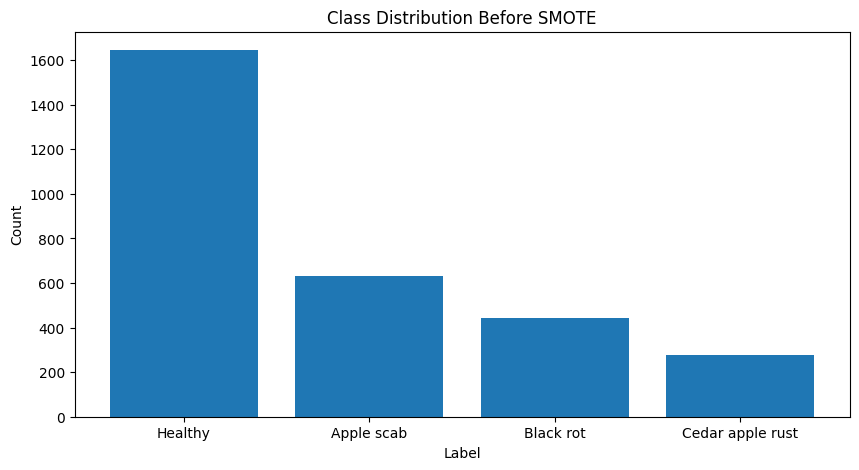

Class distribution after SMOTE:
Counter({'Apple scab': 1645, 'Black rot': 1645, 'Cedar apple rust': 1645, 'Healthy': 1645})


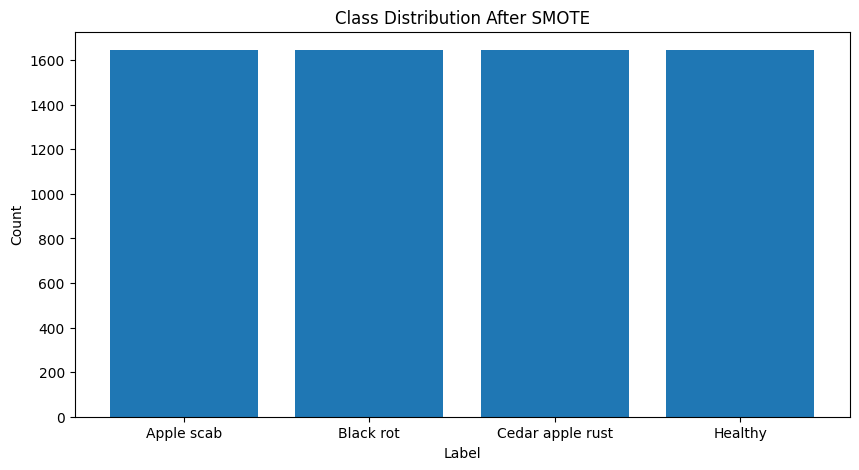

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

# Extract the features (X) and labels (y)
X = data.iloc[:, :-1]  # Select all columns except the last one as features
y = data['types']  # Select the 'types' column as the target variable

# Check the class distribution before applying SMOTE
label_counts_before = y.value_counts()
print("Class distribution before SMOTE:")
print(label_counts_before)

# Create a bar chart to visualize the class distribution before SMOTE
plt.figure(figsize=(10, 5))
plt.bar(label_counts_before.index, label_counts_before.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution Before SMOTE')
plt.show()

# Create an instance of the SMOTE class
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to balance the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the class distribution after applying SMOTE
label_counts_after = Counter(y_resampled)
print("Class distribution after SMOTE:")
print(label_counts_after)

# Create a bar chart to visualize the class distribution after SMOTE
plt.figure(figsize=(10, 5))
plt.bar(label_counts_after.keys(), label_counts_after.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution After SMOTE')
plt.show()

In [62]:
# Overwrite DataFrame with the resampled data
data = pd.DataFrame(X_resampled, columns=X.columns)
data['types'] = y_resampled

### Splitting

In [65]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,types
0,-5635.955732,88.713888,4.532089,-34.854049,-59.116986,49.963814,26.497144,0.752574,6.194279,22.444172,19.636600,7.483436,-0.208097,-0.194524,Apple scab
1,-19151.828223,130.092075,-125.919004,-21.752929,38.642661,-4.106903,11.513070,14.144452,23.417199,3.219911,-11.149159,11.682708,2.509714,-1.517949,Apple scab
2,33445.177918,-53.433240,-269.790557,-37.692779,-64.755248,14.568278,70.003753,41.958665,2.831054,12.945960,20.910142,8.578690,-1.051521,-1.492623,Apple scab
3,-13829.636241,-234.168608,-160.024404,-8.194687,12.645568,8.019279,33.974063,-12.608497,-4.981707,-13.417287,2.414239,11.934916,6.901269,-1.823742,Apple scab
4,1522.013880,-241.538256,263.672574,-44.219407,-31.595942,-3.493567,12.803523,43.745289,-19.191394,-25.473036,7.022824,2.897605,-2.076483,-3.254389,Apple scab


In [66]:
x=data.iloc[:,0:14].values

In [67]:
x

array([[-5.63595573e+03,  8.87138877e+01,  4.53208927e+00, ...,
         7.48343624e+00, -2.08097343e-01, -1.94524355e-01],
       [-1.91518282e+04,  1.30092075e+02, -1.25919004e+02, ...,
         1.16827083e+01,  2.50971366e+00, -1.51794869e+00],
       [ 3.34451779e+04, -5.34332397e+01, -2.69790557e+02, ...,
         8.57869011e+00, -1.05152077e+00, -1.49262287e+00],
       ...,
       [-6.91687752e+03, -2.77494302e+02,  7.82302073e+00, ...,
        -1.99018189e+00,  1.66308649e+00,  2.56357118e+00],
       [-5.76810205e+03, -2.69086667e+02,  5.99039829e+01, ...,
        -2.57086734e-01,  3.47802582e+00,  5.21219956e+00],
       [ 1.98108121e+03, -2.92577614e+02,  1.88135502e+02, ...,
        -2.76654139e+00,  1.30584795e+00,  4.07756895e+00]])

In [68]:
x.shape

(6580, 14)

In [69]:
y=data.iloc[:,14].values

In [70]:
y

array(['Apple scab', 'Apple scab', 'Apple scab', ..., 'Cedar apple rust',
       'Cedar apple rust', 'Cedar apple rust'], dtype=object)

In [71]:
from sklearn.preprocessing import StandardScaler
data2=StandardScaler()
x=data2.fit_transform(x)

In [72]:
import joblib

# Save the trained model to a file
joblib.dump(data2, 'models/scalers/Apple_scaler_model.pkl')

['models/scalers/Apple_scaler_model.pkl']

In [73]:
x

array([[-4.45967597e-01,  3.06715469e-01, -1.72798595e-02, ...,
         1.37693202e+00, -2.96977432e-02, -1.52047803e-01],
       [-1.40673908e+00,  4.36133438e-01, -7.55581930e-01, ...,
         2.25572946e+00,  9.13798544e-01, -6.37037918e-01],
       [ 2.33210231e+00, -1.37876080e-01, -1.56983854e+00, ...,
         1.60613991e+00, -3.22494729e-01, -6.27756864e-01],
       ...,
       [-5.37021514e-01, -8.38668680e-01,  1.34552299e-03, ...,
        -6.05647648e-01,  6.19889370e-01,  8.58700628e-01],
       [-4.55361176e-01, -8.12372239e-01,  2.96103361e-01, ...,
        -2.42956312e-01,  1.24995103e+00,  1.82933306e+00],
       [ 9.54870411e-02, -8.85844538e-01,  1.02184351e+00, ...,
        -7.68119318e-01,  4.95872930e-01,  1.41352944e+00]])

In [74]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

### Default Parameters Training

In [75]:
from sklearn.svm import SVC

# Assuming x_train is your feature matrix and y_train is your target variable as a NumPy array
svm = SVC()

# Train the SVM model
strain = svm.fit(x_train, y_train)

In [76]:
strain

SVC()

In [77]:
import joblib

# Save the trained model to a file
joblib.dump(strain, 'models/classifiers/Apple_classifier_model.pkl')

['models/classifiers/Apple_classifier_model.pkl']

### Testing

In [78]:
x_test

array([[-0.75166454, -0.11139539, -0.70337508, ...,  0.35926755,
         1.67498033, -1.29822072],
       [-0.87617753, -0.10199936,  0.16711422, ...,  0.59584414,
        -0.69399757, -0.22680394],
       [-0.83620955,  1.74314432, -0.96582901, ..., -1.38671019,
         0.39633456,  0.6919473 ],
       ...,
       [-0.44693465, -1.00130788, -0.42519048, ...,  0.47033785,
        -1.28515455, -0.26374484],
       [-0.7567938 , -0.8907111 , -0.44131022, ..., -0.17525878,
        -0.34244678,  0.80042863],
       [-0.90294445,  0.99138159, -0.78124045, ..., -1.25754128,
         0.08443239,  0.1319261 ]])

In [79]:
y_pred=strain.predict(x_test)

In [80]:
y_pred

array(['Black rot', 'Apple scab', 'Healthy', ..., 'Apple scab',
       'Cedar apple rust', 'Healthy'], dtype=object)

In [81]:
y_test

array(['Black rot', 'Apple scab', 'Healthy', ..., 'Apple scab',
       'Cedar apple rust', 'Healthy'], dtype=object)

In [82]:
print("Number of Training Data:", len(y_train))
print("Number of Testing Data:", len(y_test))

Number of Training Data: 5264
Number of Testing Data: 1316


In [83]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[296,  15,  10,  15],
       [  5, 317,   0,   1],
       [  1,   0, 318,   0],
       [ 22,   4,   0, 312]], dtype=int64)

In [84]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9445288753799392

### Testing Models

In [ ]:
main_img = cv2.imread('dataset/images/Cedar apple rust/0cd24b0c-0a9d-483f-8734-5c08988e029f___FREC_C.Rust 3762.jpg')

names = ['area', 'perimeter', 'physiological_length', 'physiological_width', 'aspect_ratio',
             'mean_r', 'mean_g', 'mean_b', 'stddev_r', 'stddev_g', 'stddev_b',
             'contrast', 'energy', 'homogeneity', 'correlation', 'dissimilarity',
             'eccentricity', 'solidity', 'equiv_diameter', 'major_axis_length', 'minor_axis_length',
             'skewness', 'kurtosis', 'hog_feature_1', 'hog_feature_2', 'hog_feature_3'
            ]
df = pd.DataFrame(columns=names)

# Preprocessing
img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gs, (25, 25), 0)
ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = np.ones((50, 50), np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# Shape features
contours, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
area = cv2.contourArea(cnt)
perimeter = cv2.arcLength(cnt, True)
x, y, w, h = cv2.boundingRect(cnt)
aspect_ratio = float(w) / h

# Color features
red_channel = img[:, :, 0]
green_channel = img[:, :, 1]
blue_channel = img[:, :, 2]

red_mean = np.mean(red_channel)
green_mean = np.mean(green_channel)
blue_mean = np.mean(blue_channel)

# Std deviation
red_std = np.std(red_channel)
green_std = np.std(green_channel)
blue_std = np.std(blue_channel)

# Texture features using GLCM matrix
glcm = graycomatrix(gs,
                distances=[1],
                angles=[0],
                symmetric=True,
                normed=True)

properties = ['contrast', 'energy', 'homogeneity', 'correlation', 'dissimilarity']
contrast = graycoprops(glcm, properties[0])
energy = graycoprops(glcm, properties[1])
homogeneity = graycoprops(glcm, properties[2])
correlation = graycoprops(glcm, properties[3])
dissimilarity = graycoprops(glcm, properties[4])

# Statistical moments
skewness = stats.skew(gs.flatten())
kurtosis = stats.kurtosis(gs.flatten())

# Additional features
labeled_img = label(closing)
regions = regionprops(labeled_img)

eccentricity = regions[0].eccentricity
solidity = regions[0].solidity
equiv_diameter = regions[0].equivalent_diameter
major_axis_length = regions[0].major_axis_length
minor_axis_length = regions[0].minor_axis_length

# HOG features
hog_features = hog(gs, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), block_norm='L2-Hys')

vector = [area, perimeter, w, h, aspect_ratio,
        red_mean, green_mean, blue_mean, red_std, green_std, blue_std,
        contrast[0][0], energy[0][0], homogeneity[0][0], correlation[0][0], dissimilarity[0][0],
        eccentricity, solidity, equiv_diameter, major_axis_length, minor_axis_length,
        skewness, kurtosis, hog_features[0], hog_features[1], hog_features[2]]

df_temp = pd.DataFrame([vector], columns=names)
df = pd.concat([df, df_temp], ignore_index=True)

pca_model = joblib.load('models/pca/Apple_pca_model.pkl')
pca = pca_model.transform(df)

scaler_model = joblib.load('models/scalers/Apple_scaler_model.pkl')
scaled = scaler_model.transform(pca)

classifier_model = joblib.load('models/classifiers/Apple_classifier_model.pkl')
results = classifier_model.predict(scaled)

print('FEATURES', df)
print('PCA', pca)
print('SCALED', scaled)
print('RESULTS', results)

### Checking

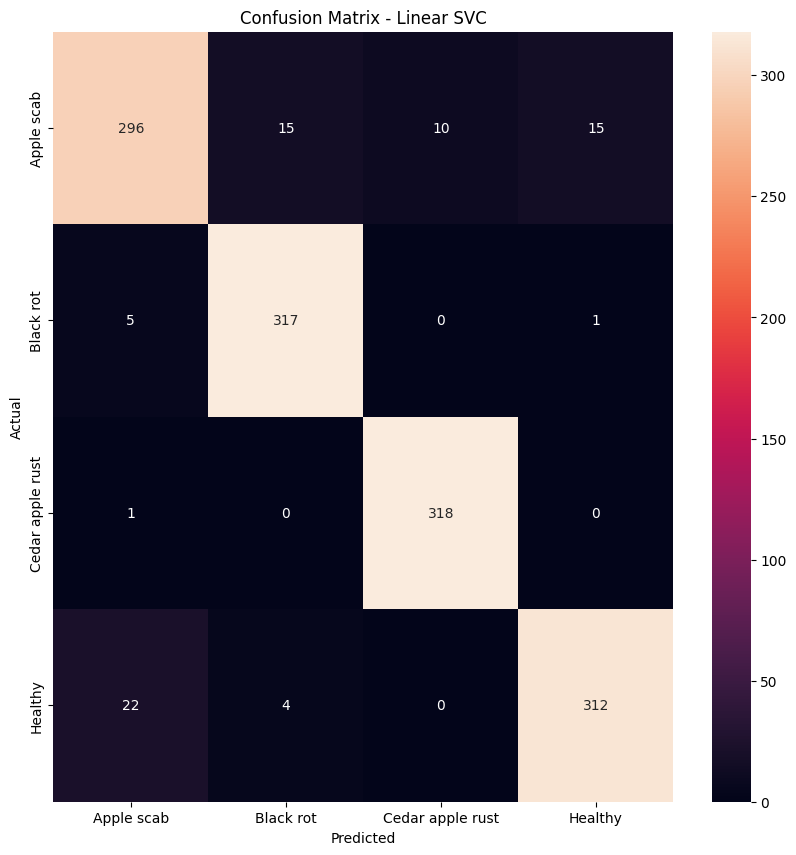

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'y_test' contains the true labels and 'y_pred' contains the predicted labels
conf_mat = confusion_matrix(y_test, y_pred, labels=data['types'].unique())

# Create the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=data['types'].unique(),
            yticklabels=data['types'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix - Linear SVC")
plt.show()

In [86]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have true labels (y_true) and predicted labels (y_pred)
y_true = y_test
y_pred = y_pred

data=pd.read_csv("dataset/csv/image_features.csv")
types = data["types"]
types_labels = types.unique()

# Compute precision, recall, and F1-score for each class
classes =  types_labels

precision = precision_score(y_true, y_pred, labels=classes, average=None, zero_division=0)
recall = recall_score(y_true, y_pred, labels=classes, average=None, zero_division=0)
f1 = f1_score(y_true, y_pred, labels=classes, average=None, zero_division=0)

# Display the results for each class
for class_label, p, r, f in zip(classes, precision, recall, f1):
    print(f"Class {class_label} - Precision: {p} \n\t\t  Recall: {r} \n\t\t  F1-Score: {f}\n")

Class Apple scab - Precision: 0.9135802469135802 
		  Recall: 0.8809523809523809 
		  F1-Score: 0.8969696969696969

Class Black rot - Precision: 0.9434523809523809 
		  Recall: 0.9814241486068112 
		  F1-Score: 0.9620637329286799

Class Cedar apple rust - Precision: 0.9695121951219512 
		  Recall: 0.9968652037617555 
		  F1-Score: 0.9829984544049459

Class Healthy - Precision: 0.9512195121951219 
		  Recall: 0.9230769230769231 
		  F1-Score: 0.9369369369369369



## Grid Search

In [87]:
import threading
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import pandas as pd

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel types
    'gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1, 10]  # Kernel coefficient (only for 'rbf', 'poly', 'sigmoid')
}

# Create an SVM model
svm = SVC()

# Create a GridSearchCV object with the SVM model and parameter grid
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

# Initialize a variable to keep track of the number of combinations
total_combinations = len(param_grid['C']) * len(param_grid['kernel']) * len(param_grid['gamma'])
combination_count = 0

# Create an empty list to store the results
results = []

# Lock for thread synchronization
results_lock = threading.Lock()

# Function to train the SVM model with a timeout
def train_svm_with_timeout(C, kernel, gamma, result_flag):
    try:
        svm = SVC(C=C, kernel=kernel, gamma=gamma)
        svm.fit(x_train, y_train)
        y_pred = svm.predict(x_test)  # Predict on the test data
        accuracy = (y_pred == y_test).mean()  # Calculate accuracy
        with results_lock:
            results.append([C, kernel, gamma, accuracy])
        result_flag[0] = True
    except Exception as e:
        result_flag[0] = False

# Fit the grid search to your training data
for C in param_grid['C']:
    for kernel in param_grid['kernel']:
        for gamma in param_grid['gamma']:
            combination_count += 1
            print(f"Combination {combination_count}/{total_combinations}: C={C}, kernel={kernel}, gamma={gamma}")

            result_flag = [False]

            t = threading.Thread(target=train_svm_with_timeout, args=(C, kernel, gamma, result_flag))
            t.start()
            t.join(timeout=300)  # Adjust the timeout value as needed

            if result_flag[0]:
                print("Accuracy on test data: ", results[-1][-1])
            else:
                print("Training took too long or encountered an error. Skipping to the next combination.")

# Create a DataFrame from the results
result_df = pd.DataFrame(results, columns=["C", "Kernel", "Gamma", "Accuracy"])

# Save the DataFrame to a CSV file
output_csv = r"dataset/csv/grid_search_results.csv"
result_df.to_csv(output_csv, index=False)

Combination 1/112: C=0.1, kernel=linear, gamma=scale
Accuracy on test data:  0.8966565349544073
Combination 2/112: C=0.1, kernel=linear, gamma=auto
Accuracy on test data:  0.8966565349544073
Combination 3/112: C=0.1, kernel=linear, gamma=0.001
Accuracy on test data:  0.8966565349544073
Combination 4/112: C=0.1, kernel=linear, gamma=0.01
Accuracy on test data:  0.8966565349544073
Combination 5/112: C=0.1, kernel=linear, gamma=0.1
Accuracy on test data:  0.8966565349544073
Combination 6/112: C=0.1, kernel=linear, gamma=1
Accuracy on test data:  0.8966565349544073
Combination 7/112: C=0.1, kernel=linear, gamma=10
Accuracy on test data:  0.8966565349544073
Combination 8/112: C=0.1, kernel=rbf, gamma=scale
Accuracy on test data:  0.9110942249240122
Combination 9/112: C=0.1, kernel=rbf, gamma=auto
Accuracy on test data:  0.9110942249240122
Combination 10/112: C=0.1, kernel=rbf, gamma=0.001
Accuracy on test data:  0.8419452887537994
Combination 11/112: C=0.1, kernel=rbf, gamma=0.01
Accuracy o

### Grid Search Training

In [88]:
import pandas as pd
grid_df=pd.read_csv("dataset/csv/grid_search_results.csv")

In [89]:
len(grid_df)

112

In [90]:
grid_df.head()

,C,Kernel,Gamma,Accuracy
0,0.1,linear,scale,0.896657
1,0.1,linear,auto,0.896657
2,0.1,linear,0.001,0.896657
3,0.1,linear,0.01,0.896657
4,0.1,linear,0.1,0.896657


In [91]:
# Find the index of the row with the highest accuracy
max_accuracy_index = grid_df['Accuracy'].idxmax()

# Get the row with the highest accuracy
row_with_highest_accuracy = grid_df.loc[max_accuracy_index]

print(row_with_highest_accuracy)

C              100.0
Kernel           rbf
Gamma            0.1
Accuracy    0.969605
Name: 95, dtype: object


In [92]:
from sklearn.svm import SVC

# Specify the parameters
C = float(row_with_highest_accuracy.C)
kernel = row_with_highest_accuracy.Kernel
gamma_value = row_with_highest_accuracy.Gamma

# Check if gamma is a string and not 'auto' or 'scale'
if isinstance(gamma_value, str):
    try:
        gamma = float(gamma_value)  # Try to convert to float
    except ValueError:
        raise ValueError("Invalid gamma value")
else:
    gamma = gamma_value  # It's either 'auto', 'scale', or a valid string

# Create an SVC with the specified parameters
svm = SVC(C=C, kernel=kernel, gamma=gamma)

# Train the model on your training data
train_grid = svm.fit(x_train, y_train)

In [93]:
train_grid

SVC(C=100.0, gamma=0.1)

In [95]:
import joblib

# Save the trained model to a file
joblib.dump(train_grid, 'models/classifiers/Apple_classifier_model.pkl')

['models/classifiers/Apple_classifier_model.pkl']

In [96]:
y_pred=train_grid.predict(x_test)

In [97]:
y_pred

array(['Black rot', 'Apple scab', 'Apple scab', ..., 'Apple scab',
       'Cedar apple rust', 'Healthy'], dtype=object)

In [98]:
y_test

array(['Black rot', 'Apple scab', 'Healthy', ..., 'Apple scab',
       'Cedar apple rust', 'Healthy'], dtype=object)

In [99]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9696048632218845

### Grid Search Checking

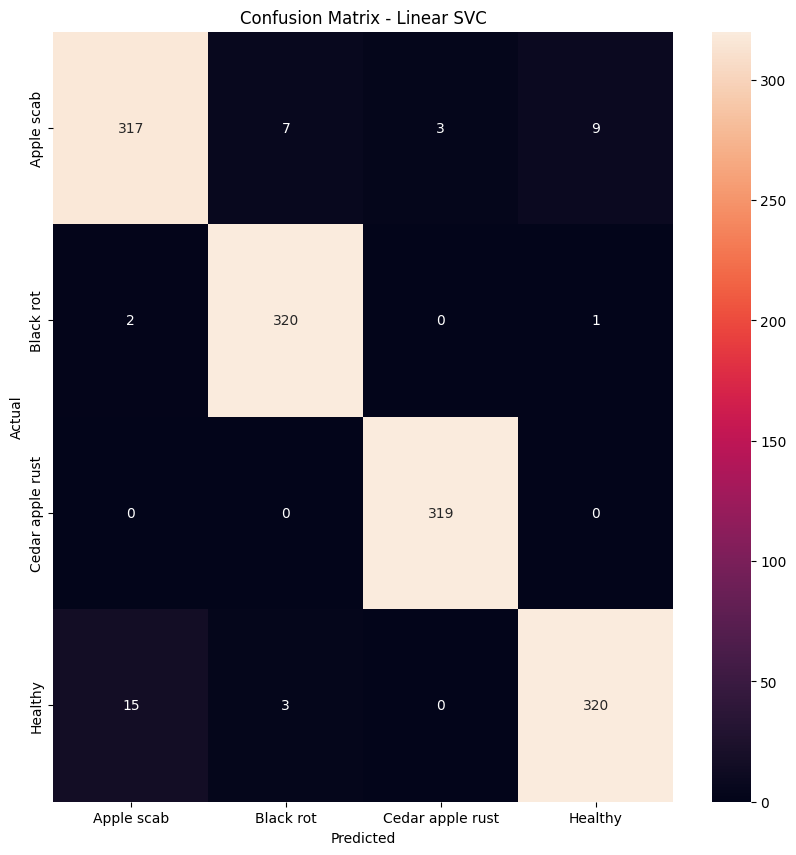

In [100]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'y_test' contains the true labels and 'y_pred' contains the predicted labels
conf_mat = confusion_matrix(y_test, y_pred, labels=data['types'].unique())

# Create the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=data['types'].unique(),
            yticklabels=data['types'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix - Linear SVC")
plt.show()

In [101]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have true labels (y_true) and predicted labels (y_pred)
y_true = y_test
y_pred = y_pred

data=pd.read_csv("dataset/csv/image_features.csv")
types = data["types"]
types_labels = types.unique()

# Compute precision, recall, and F1-score for each class
classes = types_labels

precision = precision_score(y_true, y_pred, labels=classes, average=None, zero_division=0)
recall = recall_score(y_true, y_pred, labels=classes, average=None, zero_division=0)
f1 = f1_score(y_true, y_pred, labels=classes, average=None, zero_division=0)

# Display the results for each class
for class_label, p, r, f in zip(classes, precision, recall, f1):
    print(f"Class {class_label} - Precision: {p} \n\t\t  Recall: {r} \n\t\t  F1-Score: {f}\n")

Class Apple scab - Precision: 0.9491017964071856 
		  Recall: 0.9434523809523809 
		  F1-Score: 0.9462686567164178

Class Black rot - Precision: 0.9696969696969697 
		  Recall: 0.9907120743034056 
		  F1-Score: 0.9800918836140889

Class Cedar apple rust - Precision: 0.9906832298136646 
		  Recall: 1.0 
		  F1-Score: 0.9953198127925117

Class Healthy - Precision: 0.9696969696969697 
		  Recall: 0.9467455621301775 
		  F1-Score: 0.9580838323353293

